In [13]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd

### Tarea 1
Los ejemplos ilustrativos anteriores permiten saber el número de monedas presentes en la imagen. ¿Cómo saber la cantidad de dinero presente en ella? Sugerimos identificar de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras obtener esa información y las dimensiones en milímetros de las distintas monedas, realiza una propuesta para estimar la cantidad de dinero en la imagen. Muestra la cuenta de monedas y dinero sobre la imagen. No hay restricciones sobre utilizar medidas geométricas o de color.

Una vez resuelto el reto con la imagen ideal proporcionada, captura una o varias imágenes con monedas. Aplica el mismo esquema, tras identificar la moneda del valor determinado, calcula el dinero presente en la imagen. ¿Funciona correctamente? ¿Se observan problemas?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc.

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.

In [25]:
# Leer la imagen de las monedas
img = cv2.imread('./content/monedas_5.jpg') 

# Convierte la imagen a todos de gris, mostrando el resultado
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Umbralizado binario invertido
# umbral = 200
blur = cv2.GaussianBlur(img_gris,(5,5),0)
ret, img_th1 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Buscamos los contornos
contours, hierarchy = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

# Guardamos las coordenadas del centro y el radio de cada círculo 
circles = []

for cnt in contours:
    epsilon = 0.1 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    (x,y), radius = cv2.minEnclosingCircle(approx)
    center = (int(x),int(y))
    radius = int(radius)
    if radius*2 < img.shape[0] and radius*2 < img.shape[1]:
        circles.append([center, radius])
        cv2.circle(img, center, radius, (255, 0, 0), 3)

valores = [
    [25.75, 2.00],
    [23.25, 1.00],
    [24.25, 0.50,],
    [22.25, 0.20,],
    [19.75, 0.10,],
    [21.25, 0.05,],
    [18.75, 0.02,],
    [16.25, 0.01]
]

selected = False

# Función para detectar clics en la imagen
def click(event, x, y, flags, param):
    global selected
    moneda_2 = None
    escala = 0
    total_monedas = 0
    # Si presionoo el botón izquierdo del ratón
    if event == cv2.EVENT_LBUTTONDOWN:
        # Recorro los contornos para ver si he hecho clic en alguno
        for index, (center, r) in enumerate(circles):
            # x, y
            cx, cy = center
            # Si hago click dentro del radio
            left = (x - cx)**2 + (y - cy)**2
            right = r**2
            if left <= right:
                # Determino el valor de la moneda y su tamaño
                moneda_2 = index
                break
    if moneda_2 is not None and selected is False:
        r2 = circles[moneda_2][1]
        escala = 25.75/(r2*2)
        for (center, r) in circles:
            tamaño = (r*2)*escala
            for [mm, moneda] in valores:
                if tamaño <= (mm + 0.5) and tamaño >= (mm - 0.5):
                    cv2.circle(img, center, r, (255, 0, 0), 3)
                    moneda = int(moneda*100)
                    print("Tamaño:", tamaño)
                    print("Moneda:", moneda)
                    total_monedas += moneda
        selected = True
        font = img.shape[0]/400
        grosor = int(font)+3
        cv2.putText(img, f'Total: {total_monedas/100}', (100,150), cv2.FONT_HERSHEY_SIMPLEX, font, (0,0,0), grosor)
        cv2.imshow("Testing", img)

cv2.namedWindow("Testing", cv2.WINDOW_NORMAL)

ratio = 1
if img.shape[0] > 900:
    ratio = img.shape[0] / 900
elif img.shape[1] > 1800:
    ratio = img.shape[1] / 1800
new_h = int(img.shape[0]//ratio)
new_w = int(img.shape[1]//ratio)
cv2.resizeWindow("Testing", new_w, new_h)
cv2.setMouseCallback("Testing", click)
cv2.imshow("Testing", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Tamaño: 18.33712121212121
Moneda: 2
Tamaño: 25.75
Moneda: 200


Tarea 2.

NOTA: Podemos usar técnicas de segmentación más potentes para distinguir los objetos del fondo. 
RECORDAR: No se espera una clasificación ni separación del 100%, si se consigue, pues genial, pero no es requisito.

TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

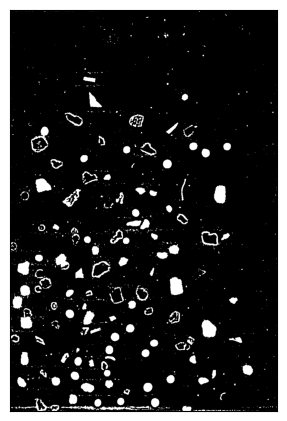

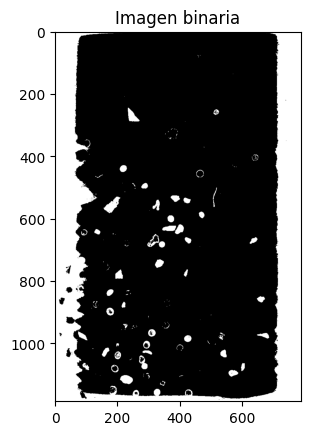

[[934965.0, 3948.0, 0.7537909683441941, 0.6661045531197302]]
       Area  Perimetro  Circularidad  Aspect Ratio
0  934965.0     3948.0      0.753791      0.666105


In [40]:
#Carga imagen directamente en grises
imgorig = cv2.imread('./content/MPs_test.jpg', cv2.IMREAD_GRAYSCALE)

img = cv2.GaussianBlur(imgorig,(5,5),0)

# Umbralizado
imth3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, \
                              cv2.THRESH_BINARY, 11, 2)


res,imth = cv2.threshold(255- imth3,120,255,cv2.THRESH_BINARY)
contornos, hierarchy= cv2.findContours(imth, 
cv2.RETR_EXTERNAL , 
cv2.CHAIN_APPROX_SIMPLE)  
img_cont = np.zeros(img.shape)
plt.figure(figsize=(20,20))
cv2.drawContours(img_cont, contornos, -1, (255,255,255), -1)  
plt.subplot(2,5,7),plt.imshow(img_cont,'gray')
plt.xticks([]),plt.yticks([])

plt.show()


    